# Named Entity Recognition

In this assignment, named entity recognition is performed using Conditional Random Field and using Stochastic Gradient Descent. 

The results obtained in metrics is as follows

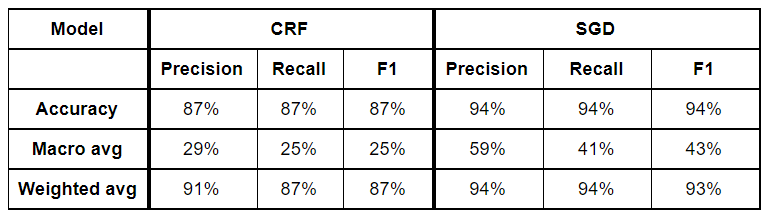

**Please find the [flowchart](https://drive.google.com/file/d/1XRJl1x2Zjuw617a9-0jQCDZxfMvnJyLV/view?usp=sharing) of this assignment.**

**Downloading the dataset**

In [1]:
!gdown --id 19CtxJxsYs8hFMXpHkcmhD612OG86943e

Downloading...
From: https://drive.google.com/uc?id=19CtxJxsYs8hFMXpHkcmhD612OG86943e
To: /content/ner_dataset.csv.zip
3.32MB [00:00, 52.2MB/s]


**Extracting the dataset**

In [2]:
!unzip /content/ner_dataset.csv.zip

Archive:  /content/ner_dataset.csv.zip
  inflating: ner_dataset.csv         


**Downloading the sklearn crfsuit for CRF model**

In [3]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 743 kB 11.6 MB/s 


**Importing the required packages and libraries**

In [4]:
import pandas as pd                                           
import numpy as np     
import sklearn                                       
from sklearn.feature_extraction import DictVectorizer          
from sklearn.model_selection import train_test_split          
from sklearn_crfsuite import CRF
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics
import warnings
warnings.filterwarnings("ignore")

**Storing the data into Pandas dataframe**

In [5]:
df = pd.read_csv('/content/ner_dataset.csv',  encoding = "ISO-8859-1")

In [6]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**Obtaining the tags which act as labels in our training. And also, obtaining total number classes in the entire dataset.**

In [7]:
y = df.Tag.values
classes = np.unique(y)
classes = classes.tolist()

# Data Preparation
Preparing our data in the form of nested list where each element contrains (word, pos, tag) pairs. This will help us with data compatibility when putting it for training in CRF model. 

In [8]:
convert_to_list = lambda sent: [(word, pos, tag) for word, pos, tag in zip(sent["Word"].values.tolist(), sent["POS"].values.tolist(), sent["Tag"].values.tolist())]
df_grouped = df.groupby("Sentence #").apply(convert_to_list)
df_sentences = [s for s in df_grouped]

**Functions for obtaining unlabelled data (word, postag) pairs and labels separatively.**

In [9]:
def word_pos_pair(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    return word,postag

def pair_sent(sent):
    return [word_pos_pair(sent, i) for i in range(len(sent))]

def sent_tags(sent):
    return [label for token, postag, label in sent]

**Getting the data using above functions and splitting the data using sklearn train_test_split**

In [10]:
X = [pair_sent(s) for s in df_sentences]
y = [sent_tags(s) for s in df_sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
del X
del y
del df_sentences

In [11]:
X_train[:10]

[[('The', 'DT')],
 [('The', 'DT')],
 [('Tribal', 'NNP')],
 [('Two', 'CD')],
 [('GDP', 'NN')],
 [('The', 'DT')],
 [('The', 'DT')],
 [('Vices', 'NNS')],
 [('Federal', 'NNP')],
 [('It', 'PRP')]]

In [12]:
y_train[:10]

[['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-org'], ['O']]

# CRF Model Definition

In [13]:
crf = CRF(algorithm='lbfgs',
          c1 = 15,
          c2 = 0.1,
          max_iterations=150,
          all_possible_transitions=True)

**Applying crf model to sets obtained above after splitting and obtaining the predicted labels. This section also generates report for various scores**

In [14]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = classes))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         2
       B-eve       0.00      0.00      0.00         2
       B-geo       0.80      0.62      0.70       655
       B-gpe       0.69      0.83      0.76       613
       B-nat       0.00      0.00      0.00         3
       B-org       0.95      0.23      0.37       524
       B-per       0.51      0.99      0.67       827
       B-tim       1.00      0.56      0.72        96
       I-art       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
       I-geo       0.00      0.00      0.00         0
       I-gpe       0.00      0.00      0.00         0
       I-nat       0.00      0.00      0.00         0
       I-org       0.00      0.00      0.00         0
       I-per       0.00      0.00      0.00         0
       I-tim       0.00      0.00      0.00         0
           O       0.99      0.94      0.96      6870

   micro avg       0.87   

# Performing One-Hot Encoding on the dataframe

**Removing the NaN values from the dataset for proper encoding.**

In [16]:
df = df.fillna(method='ffill')

**Generating the encoded vectors, and labels and classes. This section also performs test and train set splitting.**

In [17]:
X_sgd = df.drop('Tag', axis=1)
v = DictVectorizer(sparse=True)
X_sgd = v.fit_transform(X_sgd.to_dict('records'))
y_sgd = df.Tag.values
classes_sgd = classes
X_train, X_test, y_train, y_test = train_test_split(X_sgd, y_sgd, test_size = 0.20)
del X_sgd
del y_sgd

# SGD Model Definition

In [18]:
sgd = SGDClassifier()

**Applying sgd model to sets obtained above after splitting and obtaining the predicted labels. This section also generates report for various scores**

In [19]:
sgd.partial_fit(X_train, y_train, classes_sgd)
del X_train, y_train
pred_sgd = sgd.predict(X_test)
print(sklearn.metrics.classification_report(y_pred = pred_sgd, y_true = y_test, labels = classes_sgd))

              precision    recall  f1-score   support

       B-art       0.04      0.34      0.07        68
       B-eve       0.38      0.30      0.33        57
       B-geo       0.81      0.80      0.81      7682
       B-gpe       0.93      0.72      0.81      3112
       B-nat       0.67      0.22      0.33        46
       B-org       0.76      0.44      0.56      4080
       B-per       0.82      0.57      0.67      3400
       B-tim       0.52      0.64      0.57      4136
       I-art       0.57      0.07      0.12        57
       I-eve       1.00      0.06      0.11        54
       I-geo       0.71      0.61      0.66      1504
       I-gpe       0.00      0.00      0.00        31
       I-nat       0.00      0.00      0.00        13
       I-org       0.77      0.51      0.62      3373
       I-per       0.68      0.70      0.69      3471
       I-tim       0.48      0.01      0.02      1229
           O       0.97      1.00      0.98    177402

    accuracy              